In [1]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import seaborn as sns
import os
import pickle
from tqdm import tqdm
import networkx as nx

In [2]:
import os
import psutil
from nmp.nmp_tools import unique_neighbours_of_k_order
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, log_loss
from sklearn.metrics import precision_recall_curve
from IPython.display import clear_output
from tools.opera_tools import plot_graphx, DISTANCE, scattering_estimation_loss, rms_integral_root_closed_py
process = psutil.Process(os.getpid())

/home/vbelavin/home/anaconda3/envs/rootenv/lib/python3.6/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.14.2 is currently installed but you installed root_numpy against numpy 1.12.1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [3]:
%load_ext Cython

In [4]:
%%cython --cplus --compile-args=-fopenmp --link-args=-fopenmp  -f --compile-args=-DCYTHON_TRACE=1
# -a
cimport cython
import numpy as np
cimport numpy as np
from cython.parallel import prange
from libc.math cimport sqrt, fabs, log
import networkx
from libcpp.vector cimport vector
from tqdm import tqdm
from tools.opera_tools import DISTANCE
# SX, SY, SZ, TX, TY
#  0,  1,  2,  3,  4
@cython.linetrace(True)
@cython.binding(True)
@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
cdef double rms_integral_root_closed(vector[double] basetrack_left, vector[double] basetrack_right):
    cdef double dz = basetrack_right[2] - basetrack_left[2]
    cdef double dx = basetrack_left[0] - (basetrack_right[0] - basetrack_right[3] * dz)
    cdef double dy = basetrack_left[1] - (basetrack_right[1] - basetrack_right[4] * dz)
    cdef double dtx = (basetrack_left[3] - basetrack_right[3])
    cdef double dty = (basetrack_left[4] - basetrack_right[4])
    
    cdef double euclidian_distance = sqrt(dx**2 + dy**2 + dz**2)
    cdef double angle_distance = sqrt(dtx**2 + dty**2)
    
    # dz can be assigned to arbitrary value, acutally!
    dz = DISTANCE
    cdef double a = (dtx * dz) ** 2 + (dty * dz) ** 2
    cdef double b = 2 * (dtx * dz * dx +  dty * dz * dy)
    cdef double c = dx ** 2 + dy ** 2
    if a == 0.:
        return fabs(sqrt(c))# / angle_distance + euclidian_distance
    cdef double discriminant = (b ** 2 - 4 * a * c)
    cdef double log_denominator = 2 * sqrt(a) * sqrt(a + b + c) + 2 * a + b 
    cdef double log_numerator = 2 * sqrt(a) * sqrt(c) + b
    cdef double first_part = ( (2 * a + b) * sqrt(a + b + c) - b * sqrt(c) ) / (4 * a)

    
    cdef rms = fabs((discriminant * log(log_numerator / log_denominator) / (8 * sqrt(a * a * a)) + first_part))
    return rms

@cython.linetrace(True)
@cython.binding(True)
@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
cdef vector[double] node_to_vector(node, median=False):
    if median:
        return [node['features']['SX'], 
             node['features']['SY'], 
             node['features']['SZ'], 
             node['features']['TX_m'], 
             node['features']['TY_m']]
    else:
        return [node['features']['SX'], 
             node['features']['SY'], 
             node['features']['SZ'], 
             node['features']['TX'], 
             node['features']['TY']]

@cython.linetrace(True)
@cython.binding(True)
@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
def generate_distances(graphx_nodes, threshold=200, layers=3):
    cdef int N = len(graphx_nodes)
    cdef int i, j
    cdef double r
    ebunch = []
    graphx_nodes_preprocessed = []
    for i in range(N):
        node_id, node = graphx_nodes[i]
        node = node_to_vector(node)
        graphx_nodes_preprocessed.append((node_id, node))

    for i in tqdm(range(N)):
        node_id_left, node_left = graphx_nodes_preprocessed[i]
        for j in range(i):
            node_id_right, node_right = graphx_nodes_preprocessed[j]

            if node_right[2] > node_left[2] and  node_right[2] - node_left[2] <= DISTANCE * layers:
                r = rms_integral_root_closed(node_left, node_right)
                # ... and those who is a bad match
                if r < threshold:
                    ebunch.append((node_id_left, 
                                   node_id_right, 
                                   {'weight': r}))
                    
            elif node_left[2] > node_right[2] and node_left[2] - node_right[2] <= DISTANCE * layers:
                r = rms_integral_root_closed(node_right, node_left)
                # ... and those who is a bad match
                if r < threshold:
                    ebunch.append((node_id_left, 
                                   node_id_right, 
                                   {'weight': r}))
            else:
                pass
            
    return ebunch

In [5]:
from math import fabs, sqrt, log
from copy import deepcopy
def merge_clusters(clusters: list, cl_size: int, weight: float):
    true_clusters = []
    noise_clusters = []
    for cluster in clusters:
        if cluster.is_cluster:
            true_clusters.append(cluster)
        else:
            noise_clusters.append(cluster)
            
    if len(true_clusters) == 1:
        resulted_cluster = true_clusters[0].append(weight=weight, clusters=noise_clusters)
    else:
        resulted_cluster = ClusterHDBSCAN(weight=weight, cl_size=cl_size, clusters=clusters)
    
    return resulted_cluster

def find_cluster_with_node(clusters, node):
    for cluster in clusters:
        if node in cluster:
            return cluster
        
        
class ClusterHDBSCAN(object):
    def __init__(self, weight: float, cl_size: int, clusters: list = None, nodes: list = None):
        # init
        self.nodes = set()
        self.weights_nodes_dict = defaultdict(set)
        
        self.weight_death = weight
        self.lambda_death = 1. / weight
        
        self.weight_birth = weight
        self.lambda_birth = 1. / weight
        
        
        self.children = []
        self.falling_out_points = []
        
        assert clusters is not None or nodes is not None
        if clusters is not None:
            for cluster in clusters:
                self.nodes.update(cluster.nodes)
                self.weights_nodes_dict[weight].update(cluster.nodes)
                if cluster.is_cluster:
                    cluster.set_weight_birth(weight)
                    self.children.append(cluster)
                else:
                    self.falling_out_points.append(cluster)
        else:
            self.nodes.update(nodes)
            self.weights_nodes_dict[weight].update(nodes)
            
        self.is_cluster = len(self) >= cl_size
        self.is_noise = not self.is_cluster
        self.stability = None
        
        
    def append(self, weight: float, clusters: list):
        """
        Adding
        """
        for cluster in clusters:
            self.nodes.update(cluster.nodes)
            self.weights_nodes_dict[weight].update(cluster.nodes)
        self.weight_birth = weight
        self.lambda_birth = 1 / weight
        return self
    
    def __iter__(self):
        for child in self.children:
            yield child
    
    def __contains__(self, node):
        return node in self.nodes
    
    def __len__(self):
        return len(self.nodes)
    
    def set_weight_birth(self, weight: float):
        self.weight_birth = weight
        self.lambda_birth = 1 / weight
        
    def calculate_stability(self):
        self.stability = 0.
        for weight in self.weights_nodes_dict:
            self.stability += len(self.weights_nodes_dict[weight]) * (1. / weight - self.lambda_birth)
            
def calc_stabilities(root):
    root.calculate_stability()
    for child in root:
        calc_stabilities(child)
        
def class_disbalance(cluster, graph):
    subgraph = graph.subgraph(cluster.nodes)
    signal = []
    for _, node in subgraph.nodes(data=True):
        signal.append(node['signal'])
    return list(zip(*np.unique(signal, return_counts=True)))

def flat_clusters(root):
    if root.is_cluster:
        yield root
    for child in root:
        for cluster in flat_clusters(child):
            yield cluster
            
def reed_stabilities(root, level=0):
    print('    ' * (level - 1) + '+---' * (level > 0), end='')
    print('len={}'.format(len(root)), end=' ')
    print('stability={:.2f}'.format(root.stability))
    for child in root:
        reed_stabilities(child, level + 1)

def print_class_disbalance_for_all_clusters(root, graph, level=0):
    class_disbalance_tuples = class_disbalance(root, graph)
    print('    ' * (level - 1) + '+---' * (level > 0), end='')
    print('len={}'.format(len(root)))
    print('    ' * (level), end='')
    print(class_disbalance_tuples, end=' ')
    print('stability={:.2f}'.format(root.stability))
    for child in root:
        print_class_disbalance_for_all_clusters(child, graph, level + 1)
        
def leaf_clusters(root):
    if root.is_cluster and len(root.children) == 0:
        yield root
    for child in root:
        for cluster in leaf_clusters(child):
            yield cluster

In [69]:
MAX = 'MAX'
PERCENTILE90 = 'PERCENTILE90'
MEDIAN = 'MEDIAN'

def run_hdbscan(G, k=3, cl_size = 100, max_strategy=MAX):
    ### core distances
    core_k = defaultdict(float)
      
    for node_id in G.nodes():
        neighbours = unique_neighbours_of_k_order(G, node_id, k)
        distances = [0.]
        for neighbour in neighbours:
            if 0 < neighbours[neighbour] <= k:
                distances.append(nx.shortest_path_length(G, node_id, neighbour))
        if max_strategy == MAX:
            core_k[node_id] = np.max(distances)
        elif max_strategy == PERCENTILE90:
            core_k[node_id] = np.percentile(distances, q=90)
        elif max_strategy == MEDIAN:
            core_k[node_id] = np.median(distances)

    ### weights
    for node_id_left, node_id_right, edge in G.edges(data=True):        
        edge['weight'] = max(
                       core_k[node_id_left], 
                       core_k[node_id_right], 
                       edge['weight']
        )

    ### minimum spanning tree
    G_mst = nx.minimum_spanning_tree(G)
    
    
    edges = list(G_mst.edges(data=True))
    edges = [(edge[0], edge[1], edge[2]['weight']) for edge in edges]
    edges = sorted(edges, key=lambda x: x[2])

    edges_groups = defaultdict(list)
    for edge in edges:
        edges_groups[edge[2]].append((edge[0], edge[1]))        

    clusters = []
    for node_id in G_mst.nodes():
        clusters.append(ClusterHDBSCAN(cl_size=cl_size, weight=np.inf, nodes=[node_id]))
        
    for weight in edges_groups:
        clusters_to_merge_pairs = []
        for i, j in edges_groups[weight]:
            clusters_to_merge_pairs.append([find_cluster_with_node(clusters, i), find_cluster_with_node(clusters, j)])
        g = nx.Graph()
        for clusters_to_merge_pair in clusters_to_merge_pairs:
            g.add_path(clusters_to_merge_pair)
        for clusters_to_merge in nx.connected_components(g):
            for cluster in clusters_to_merge:
                clusters.remove(cluster)
            cluster = merge_clusters(clusters=clusters_to_merge, cl_size=cl_size, weight=weight)
            clusters.append(cluster)
            
    root = clusters[0]
    calc_stabilities(root)
    
    # smarter choose it
    leafs = list(leaf_clusters(root))
    
    return root, leafs

## HDBSCAN для нахождения ливней

In [70]:
import glob

In [71]:
R = 'R'
ENERGY = 'ENERGY'
LIKELIHOOD = 'LIKELIHOOD'

def run_hdbscan_on_graphx(graphx, threshold=200, cl_size=200, k=1, weight_strategy=R):
    showers_data = graphx.graph['showers_data']
    
    graphx_nodes = list(graphx.nodes(data=True))
    ebunch = generate_distances(graphx_nodes, layers=4, threshold=threshold)
    
    G = nx.Graph()
    G.add_edges_from(ebunch)
    for node_id in G.nodes():
        G.node[node_id].update(graphx.node[node_id])
    
    graphx = G
    
    showers_data_dict = {}
    showers_data_dict['clusters'] = []
    for shower in showers_data:
        showers_data_dict[shower['N']] = shower
        showers_data_dict[shower['N']]['seen'] = 0
        showers_data_dict[shower['N']]['stuck'] = 0
        showers_data_dict[shower['N']]['clusters'] = []
    
    edges_to_delete = []
    for i,j,edge in graphx.edges(data=True):
        if (edge['weight'] > threshold):
            edges_to_delete.append((i, j))
    graphx.remove_edges_from(edges_to_delete)

    
    degrees = graphx.degree
    nodes_to_delete = []
    for node, degree in degrees:
        if degree == 0:
            nodes_to_delete.append(node)

    graphx.remove_nodes_from(nodes_to_delete)

    lengths = []
    connected_components = []
    for connected_component in nx.connected_component_subgraphs(graphx):
        if len(connected_component) > cl_size:
            connected_components.append(connected_component)
            lengths.append(len(connected_component))
            
            
    all_clusters = []
    roots = []
    for G in tqdm(connected_components, leave=False):
        root, leafs = run_hdbscan(G, cl_size=cl_size, k=k)
        roots.append(root)
        all_clusters.extend(leafs)

    showers_data_cleaned = []

    for leaf in all_clusters:
        subgraphx = graphx.subgraph(leaf.nodes)
        showers_data_dict['clusters'].append(nx.Graph(subgraphx))
        signals_subgraphx = []
        
        for _, node in subgraphx.nodes(data=True):
            signals_subgraphx.append(node['signal'])
            
        labels, labels_counts = np.unique(signals_subgraphx, return_counts=True)

        density = labels_counts / np.sum(labels_counts)
        if np.min(density) > 0.2:
            stucked = True
        else:
            stucked = False

        for label, label_count in zip(labels, labels_counts):
            if label > 0 and label_count / showers_data_dict[label]['numtracks'] > 0.2:
                showers_data_dict[label]['seen'] += 1
                showers_data_dict[label]['stuck'] += stucked
                showers_data_dict[label]['clusters'].append(nx.Graph(subgraphx))
            
    return roots, showers_data_dict

In [72]:
showers_data_dict_list = []

In [73]:
files = glob.glob('./data/brick_with_50_showers_*_cleaned.pkl')[:3]

In [49]:
%%time
for file in files:
    print(file)
    graphx = nx.Graph(nx.read_gpickle(file))
    
    roots, showers_data_dict = run_hdbscan_on_graphx(graphx=graphx, threshold=300, 
                                                     cl_size=100, k=2, weight_strategy=R)
    
    showers_data_dict_list.append(showers_data_dict)

./data/brick_with_50_showers_9_cleaned.pkl


100%|██████████| 28543/28543 [02:13<00:00, 214.31it/s]


./data/brick_with_50_showers_8_cleaned.pkl


100%|██████████| 28238/28238 [02:31<00:00, 185.80it/s]


./data/brick_with_50_showers_14_cleaned.pkl


100%|██████████| 30505/30505 [02:33<00:00, 198.55it/s]


CPU times: user 34min 38s, sys: 23.6 s, total: 35min 1s
Wall time: 35min 19s


## Efficiency estimation

In [55]:
n_correctly = 0
n_tot = 0
n_broken = 0
n_stuck = 0
n_lost = 0
for showers_data_dict in showers_data_dict_list:
    for key in showers_data_dict:
        if key=='clusters':
            continue
        n_tot += 1
        if len(showers_data_dict[key]['clusters']) > 1:
            n_broken += 1
        elif showers_data_dict[key]['stuck']:
            n_stuck += 1
        elif len(showers_data_dict[key]['clusters']):
            n_correctly += 1
        else:
            n_lost += 1

In [56]:
n_correctly / n_tot

0.9266666666666666

In [57]:
n_stuck / n_tot

0.03333333333333333

In [58]:
n_broken / n_tot

0.013333333333333334

In [59]:
n_lost / n_tot

0.02666666666666667

## Energy estimation

In [60]:
E = []
x1 = []
for showers_data_dict in showers_data_dict_list:
    for key in showers_data_dict:
        if key == 'clusters':
            continue
        if not (len(showers_data_dict[key]['clusters']) == 1 and (showers_data_dict[key]['stuck'] == 0)):
            continue
        shower = showers_data_dict[key]['clusters'][0]
        x1.append(
            len(shower)
        )
        E.append(
            showers_data_dict[key]['ele_P']
        )
        
x1 = np.array(x1)
E = np.array(E)

In [61]:
from sklearn.linear_model import RANSACRegressor
import sklearn

-0.016710962689141514 0.29528515066634453


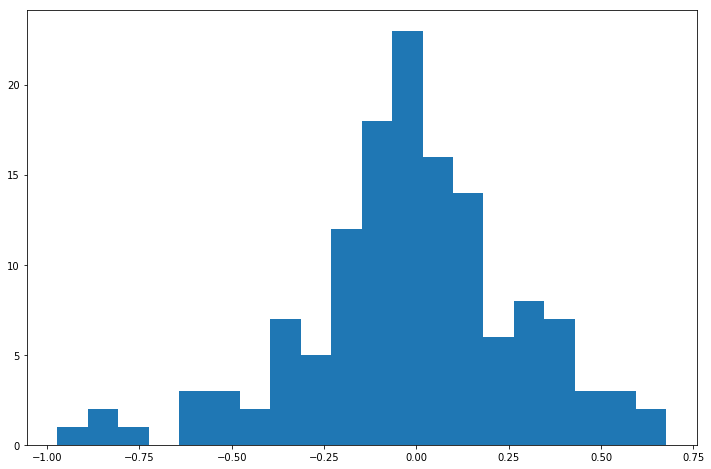

In [62]:
r = RANSACRegressor()

r.fit(X=x1.reshape((-1, 1)), y=E)

pred = r.predict(x1.reshape((-1, 1)))
resolutions = list()
for l, e in zip(pred, E):
    resolutions.append((e - l) / e)
resolutions = np.array(resolutions)
resolutions = resolutions[(resolutions > -1) & (resolutions < 1)]
print (np.mean(resolutions), np.std(resolutions))
plt.figure(figsize=(12, 8))
plt.hist(resolutions, bins=20);

## X, Y, Z estimation

In [63]:
xs_true = []
x1 = []

ys_true = []
y1 = []

zs_true = []
z1 = []

tx_true = []
tx_1 = []

ty_true = []
ty_1 = []


for showers_data_dict in showers_data_dict_list:
    for key in showers_data_dict:
        if key == 'clusters':
            continue
        if not (len(showers_data_dict[key]['clusters']) == 1 and (showers_data_dict[key]['stuck'] == 0)):
            continue
            
            
        xs_true.append(showers_data_dict[key]['ele_x'])
        ys_true.append(showers_data_dict[key]['ele_y'])
        zs_true.append(showers_data_dict[key]['ele_z'])
        tx_true.append(showers_data_dict[key]['ele_sx'])
        ty_true.append(showers_data_dict[key]['ele_sy'])
        
        shower = showers_data_dict[key]['clusters'][0]
        xs = []
        ys = []
        zs = []
        tx = []
        ty = []
        
        for i, node in shower.nodes(data=True):
            xs.append(node['features']['SX'])
            ys.append(node['features']['SY'])
            zs.append(node['features']['SZ'])
            tx.append(node['features']['TX'])
            ty.append(node['features']['TY'])
        
        lr = sklearn.linear_model.TheilSenRegressor()
        xs = np.array(xs)
        ys = np.array(ys)
        zs = np.array(zs)
        tx = np.array(tx)
        ty = np.array(ty)
        
        x1.append(np.median(xs[np.argsort(zs)][:2]))
        y1.append(np.median(ys[np.argsort(zs)][:2]))
        z1.append(np.median(zs[np.argsort(zs)][:2]))

        K = 40
        lr.fit(zs[np.argsort(zs)][:K].reshape((-1, 1)), xs[np.argsort(zs)][:K])
        lr.coef_[0]
        tx_1.append(lr.coef_[0])

        K = 40
        lr.fit(zs[np.argsort(zs)][:K].reshape((-1, 1)), ys[np.argsort(zs)][:K])
        lr.coef_[0]
        ty_1.append(lr.coef_[0])
        #ty_1.append(np.median(ys[np.argsort(zs)][:1]))
xs_true = np.array(xs_true)
x1 = np.array(x1)

ys_true = np.array(ys_true)
y1 = np.array(y1)

zs_true = np.array(zs_true)
z1 = np.array(z1)

tx_true = np.array(tx_true)
tx_1 = np.array(tx_1)

ty_true = np.array(ty_true)
ty_1 = np.array(ty_1)

In [64]:
r = RANSACRegressor(base_estimator=sklearn.linear_model.TheilSenRegressor())

r.fit(X=x1.reshape((-1, 1)), y=xs_true)

pred = r.predict(x1.reshape((-1, 1)))

print(np.mean(np.abs((pred - xs_true) / 1000)), np.sqrt(np.mean(np.abs((pred - xs_true) / 1000)**2)))

0.19522654241831527 0.7933234035530693


In [65]:
r = RANSACRegressor(base_estimator=sklearn.linear_model.TheilSenRegressor())

r.fit(X=y1.reshape((-1, 1)), y=ys_true)

pred = r.predict(y1.reshape((-1, 1)))

print(np.mean(np.abs((pred - ys_true) / 1000)), np.sqrt(np.mean(np.abs((pred - ys_true) / 1000)**2)))

0.17850975027679533 0.6473340075491475


In [66]:
r = RANSACRegressor(base_estimator=sklearn.linear_model.TheilSenRegressor())

r.fit(X=z1.reshape((-1, 1)), y=zs_true)

pred = r.predict(z1.reshape((-1, 1)))

print(np.mean(np.abs((pred - zs_true) / 1000)), np.sqrt(np.mean(np.abs((pred - zs_true) / 1000)**2)))

0.9767267178296811 3.640675018752892


In [67]:
r = RANSACRegressor(base_estimator=sklearn.linear_model.TheilSenRegressor())

r.fit(X=tx_1.reshape((-1, 1)), y=tx_true)

pred = r.predict(tx_1.reshape((-1, 1)))

print(np.mean(np.abs((pred - tx_true))), np.sqrt(np.mean(np.abs((pred - tx_true))**2)))

0.016006080517343882 0.039812952905965864


In [68]:
r = RANSACRegressor(base_estimator=sklearn.linear_model.TheilSenRegressor())

r.fit(X=ty_1.reshape((-1, 1)), y=ty_true)

pred = r.predict(ty_1.reshape((-1, 1)))

print(np.mean(np.abs((pred - ty_true))), np.sqrt(np.mean(np.abs((pred - ty_true))**2)))

0.01329840785658412 0.021618986584894438
